# OllamaFunctions

This notebook shows how to use an experimental wrapper around Ollama that gives it the same API as OpenAI Functions.

Note that more powerful and capable models will perform better with complex schema and/or multiple functions. The examples below use llama3 and phi3 models.
For a complete list of supported models and model variants, see the [Ollama model library](https://ollama.ai/library).

## Setup

Follow [these instructions](https://github.com/jmorganca/ollama) to set up and run a local Ollama instance.

## Usage

You can initialize OllamaFunctions in a similar way to how you'd initialize a standard ChatOllama instance:

In [1]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions

model = OllamaFunctions(model="llama3", format="json")

You can then bind functions defined with JSON Schema parameters and a `function_call` parameter to force the model to call the given function:

In [2]:
model = model.bind_tools(
    tools=[
        {
            "name": "get_current_weather",
            "description": "Get the current weather in a given location",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city and state, " "e.g. San Francisco, CA",
                    },
                    "unit": {
                        "type": "string",
                        "enum": ["celsius", "fahrenheit"],
                    },
                },
                "required": ["location"],
            },
        }
    ],
    function_call={"name": "get_current_weather"},
)

Calling a function with this model then results in JSON output matching the provided schema:

In [3]:
from langchain_core.messages import HumanMessage

model.invoke("what is the weather in Boston?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_weather', 'arguments': '{"location": "Boston, MA"}'}}, id='run-1791f9fe-95ad-4ca4-bdf7-9f73eab31e6f-0')

## Structured Output

One useful thing you can do with function calling using `with_structured_output()` function is extracting properties from a given input in a structured format:

In [4]:
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


# Schema for structured response
class Person(BaseModel):
    name: str = Field(description="The person's name", required=True)
    height: float = Field(description="The person's height", required=True)
    hair_color: str = Field(description="The person's hair color")


# Prompt template
prompt = PromptTemplate.from_template(
    """Alex is 5 feet tall. 
Claudia is 1 feet taller than Alex and jumps higher than him. 
Claudia is a brunette and Alex is blonde.

Human: {question}
AI: """
)

# Chain
llm = OllamaFunctions(model="phi3", format="json", temperature=0)
structured_llm = llm.with_structured_output(Person)
chain = prompt | structured_llm

### Extracting data about Alex

In [5]:
alex = chain.invoke("Describe Alex")
alex

Person(name='Alex', height=5.0, hair_color='blonde')

### Extracting data about Claudia

In [6]:
claudia = chain.invoke("Describe Claudia")
claudia

Person(name='Claudia', height=6.0, hair_color='brunette')

## OllamaFunctions and Agents

`OllamaFunctions` currently only supports creating agents using `LangGraph`.  
An example of a simple tool calling agent built with LangGraph is shared below.  
Building agents using the now legacy [`AgentExecutor`](https://python.langchain.com/v0.2/docs/how_to/agent_executor/) is not supported.

### LangGraph Agent With Tool Calling

Below is an example of a simple Tool Calling LangGraph Agent using OllamaFunctions

### Install dependencies

In [4]:
%%capture
%pip install langchain-core==0.2.9 langchain-community==0.2.5 langchain-experimental==0.0.61 langgraph==0.0.69 duckduckgo-search==6.1.7 httpx==0.27.0

### Imports

In [6]:
from typing import List

from IPython.display import Image, display
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.tools import tool
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt import ToolNode

### Define Tools

Here we have created 4 custom tools and used an existing tool for our toolset.

In [7]:
@tool
def multiply(a: int, b: int) -> int:
    """Tool to multiply two numbers"""
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Tool to add two numbers"""
    return a + b


@tool
def call_miracle(request: str) -> str:
    """Tool to call miracle"""
    return f"You asked for {request}, but I can't do that"


@tool
def grant_wish(wish: str) -> str:
    """Tool to grant wish"""
    return f"You asked for {wish}. Your wish is my command!"


tools = [multiply, add, call_miracle, grant_wish, DuckDuckGoSearchRun(max_results=2)]

# tool_node will be used as a node within the LangGraph agent
tool_node = ToolNode(tools)

### Initialize LLM and bind tools

You can use any tool calling capable LLM along with a model that offers good JSON support.  
We have use `OllamaFunctions` with the `phi3` model here.  
The complete list of natively supported [LLMs with tool calling can be found here](https://python.langchain.com/v0.1/docs/integrations/chat/)  

We initialize `llm` and add tools description on it by calling `bind_tools` function on it.  
This doesn't change `llm` itself, but returns a new LLM object that is aware of the tools specifications which we store as `llm_with_tools`.  

We will use `llm_with_tools` for any tool aware LLM calls and use `llm` for other, non tool related LLM calls.

In [8]:
llm = OllamaFunctions(model="phi3", format="json", temperature=0)
llm_with_tools = llm.bind_tools(tools)

### MessageGraph

[MessageGraph](https://python.langchain.com/v0.1/docs/integrations/chat/) is a simple `LangGraph` state type where every node receives a list of messages as input and returns one or more messages as output.  

This should be suitable for may use cases where you only need to track messages as part of the graph state.

In [9]:
builder = MessageGraph()

### Add nodes to graph

Graph nodes have a name and take a callables as a second argument which are runnables that get invoked and are passed the entire state object.  

Since `MessageGraph` is essentially just a collection of messages, you can use LLMs as the callable parameter.  

* `oracle`: We pass `llm_with_tools` as this node with identify which tool needs to be called to complete the current request.
* `tools`: We pass `tool_node` as the callable. If the last message in the state is an `AIMessage` with `tool_calls`, this node will use that information to call the approprtate tool from our toolset with the parameters specified in `tool_calls`.
* `llm`: We pass `llm` as the callable. This node will take all the messages generated thus far and use that context to generate a new message. The expected outcome is the model's interpretation of the results from the tool run within the context of the initial question that was asked of the agent.

In [10]:
builder.add_node("oracle", llm_with_tools)
builder.add_node("tools", tool_node)
builder.add_node("llm", llm)

### Connect agent nodes with edges

This will be a simple linear graph.

* `oracle` is the entry point.
* `tools` node will be called after `oracle`.
* `llm` node will be called after `tools`.
* graph ends with the execution of `llm` node.

In [11]:
builder.add_edge("oracle", "tools")
builder.add_edge("tools", "llm")
builder.add_edge("llm", END)
builder.set_entry_point("oracle")
graph = builder.compile()

### Visualizing the graph agent

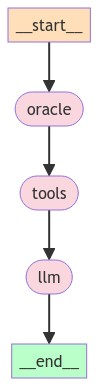

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))

Utility functions to pretty print messages

In [13]:
def trim_content(content: str) -> str:
    if len(content) < 200:
        return content
    else:
        return content[:200] + "..."


def pretty_print(message: BaseMessage):
    print(f"type: {message.type}", end="")
    if isinstance(message, AIMessage) and message.tool_calls:
        print(f", tool_calls: {message.tool_calls}", end="")
    elif isinstance(message, ToolMessage):
        print(f", name: {message.name}", end="")
    if message.content:
        print(f", content: {trim_content(message.content)}", end="")
    print("\n")


def pretty_print_messages(messages: List[BaseMessage]):
    [pretty_print(message) for message in messages]

### Running the Agent

Testing `add` custom tool

In [14]:
result = graph.invoke(("human", "What is the sum of 2 and 3?"))
pretty_print_messages(result)

type: human, content: What is the sum of 2 and 3?

type: ai, tool_calls: [{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_cdf1684191ed4cd0beded74ab796177e'}]

type: tool, name: add, content: 5

type: ai, content: The sum of 2 and 3 is 5.



Testing `multiply` custom tool

In [15]:
result = graph.invoke(("human", "What is 523 x 412?"))
pretty_print_messages(result)

type: human, content: What is 523 x 412?

type: ai, tool_calls: [{'name': 'multiply', 'args': {'a': 523, 'b': 412}, 'id': 'call_bd0acf5c9c024462afe534430afcd9a3'}]

type: tool, name: multiply, content: 215476

type: ai, content: The result of multiplying 523 by 412 is 215,476.



Testing `call_miracle` custom tool

In [16]:
result = graph.invoke(("human", "I need a miracle. I need it to rain tomorrow."))
pretty_print_messages(result)

type: human, content: I need a miracle. I need it to rain tomorrow.

type: ai, tool_calls: [{'name': 'call_miracle', 'args': {'request': 'I need it to rain tomorrow'}, 'id': 'call_d5c1f3a4abf348db842ade4ba789acfb'}]

type: tool, name: call_miracle, content: You asked for I need it to rain tomorrow, but I can't do that

type: ai, content: I'm sorry, as an AI, I don't have the ability to control weather conditions.



Testing `grant_wish` custom tool

In [17]:
result = graph.invoke(("human", "I wish for world peace."))
pretty_print_messages(result)

type: human, content: I wish for world peace.

type: ai, tool_calls: [{'name': 'grant_wish', 'args': {'wish': 'I wish for world peace.'}, 'id': 'call_b4cc44283fa1497ca2ed0c0325752702'}]

type: tool, name: grant_wish, content: You asked for I wish for world peace.. Your wish is my command!

type: ai, content: That's a beautiful sentiment, and while one person's wishes can't directly change the world, it's important to remember that every positive action contributes towards peace. Let's continue working tog...



Testing `duckduckgo_search` tool `DuckDuckGoSearchRun`

In [18]:
result = graph.invoke(("human", "What is tomorrows weather in Austin, TX?"))
pretty_print_messages(result)

type: human, content: What is tomorrows weather in Austin, TX?

type: ai, tool_calls: [{'name': 'duckduckgo_search', 'args': {'query': "tomorrow's weather in Austin, Texas"}, 'id': 'call_bdb479d2ebe540b6b62d490e71428737'}]

type: tool, name: duckduckgo_search, content: Austin Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for the Austin area. Austin, TX Weather - Tomorrow's For...

type: ai, content: Based on the latest weather forecast from Weather Underground and NOAA National Weather Service, tomorrow's weather in Austin, TX will be mostly sunny with a high temperature of around 96°F. The heat ...

